<img src="img/dsci572_header.png" width="600">

# Cat Breed Classifier
## Convolutional Neural Network using Pre-Trained Model vs Custom Model

Three Convolutional Neural Network models built here are to compare the performance difference between custom and pre-trained models.

Dataset used in this classifier can be found here: [dataset](https://www.kaggle.com/solothok/cat-breed)
Data includes 6 different cat breeds, and the goal of the classifier is to be able to tell which breed a cat is given their image.

In [1]:
!pip install torchsummary
!pip install ax-platform

     |████████████████████████████████| 934 kB 617 kB/s            
     |████████████████████████████████| 325 kB 30.1 MB/s            
     |████████████████████████████████| 310 kB 30.3 MB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for gpytorch: filename=gpytorch-1.6.0-py2.py3-none-any.whl size=509894 sha256=d7ee845e37e9756220b331d452174627e6bb532dd241d0ab61995b38942d2e59
  Stored in directory: /root/.cache/pip/wheels/66/b5/89/34c06ad393a6feb72b4cdde46d0f1c667f3e2632960f9df109
Successfully built gpytorch


In [2]:
import numpy as np
import pandas as pd
import torch
import torchvision
from torchsummary import summary
from torch import nn, optim

from torchvision import datasets, transforms, utils, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

from ax.service.managed_loop import optimize
from ax.plot.contour import plot_contour
from ax.plot.trace import optimization_trace_single_method
from ax.utils.notebook.plotting import render, init_notebook_plotting
from ax.utils.tutorials.cnn_utils import train, evaluate

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14, 'axes.labelweight': 'bold', 'axes.grid': False})

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cuda


In [4]:
# Helper Functions
def trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=5, verbose=True):
    """Simple training wrapper for PyTorch network."""
    
    train_accuracy = []
    valid_accuracy = []
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        for X, y in train_loader:
            if device.type == 'cuda':
                X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        train_accuracy.append(train_batch_acc / len(train_loader))
        
        # Validation
        model.eval()
        with torch.no_grad():
            for X, y in valid_loader:
                if device.type == 'cuda':
                    X, y = X.to(device), y.to(device)
                y_hat = model(X)
                _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
                loss = criterion(y_hat, y)
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        valid_accuracy.append(valid_batch_acc / len(valid_loader))
        model.train()
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}")
    
    return {"train_accuracy": train_accuracy, "valid_accuracy": valid_accuracy}


def get_features(model, train_loader, valid_loader):
    """Extract output of the DenseNet model"""
    
    with torch.no_grad():  # turn off computational graph stuff
        Z_train = torch.empty((0, 1024))  # Initialize empty tensors
        y_train = torch.empty((0))
        Z_valid = torch.empty((0, 1024))
        y_valid = torch.empty((0))
        for X, y in train_loader:
            Z_train = torch.cat((Z_train, model(X)), dim=0)
            y_train = torch.cat((y_train, y))
        for X, y in valid_loader:
            Z_valid = torch.cat((Z_valid, model(X)), dim=0)
            y_valid = torch.cat((y_valid, y))
    return Z_train.detach(), y_train.detach(), Z_valid.detach(), y_valid.detach()

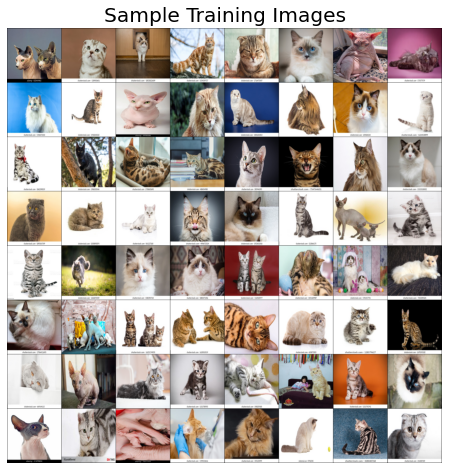

In [5]:
TRAIN_DIR = "./data/cat-breed/TRAIN/"
VALID_DIR = "./data/cat-breed/TEST/"
IMAGE_SIZE = (200, 200)
BATCH_SIZE = 64

data_transforms = transforms.Compose([transforms.Resize(IMAGE_SIZE), transforms.ToTensor()])

def get_data_loaders():
    train_dataset = torchvision.datasets.ImageFolder(root=TRAIN_DIR, transform=data_transforms)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    valid_dataset = torchvision.datasets.ImageFolder(root=VALID_DIR, transform=data_transforms)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
    return train_loader, valid_loader

# Plot samples
train_loader, valid_loader = get_data_loaders()
sample_batch = next(iter(train_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));

### Custom Model

In [6]:
class CatClassifierNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 8, (5, 5)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.2),
            
            nn.Conv2d(8, 4, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((3, 3)),
            nn.Dropout(0.2),
            
            nn.Flatten(),
            nn.Linear(4096, 128),
            nn.ReLU(),
            nn.Linear(128, 6)
        )
        
    def forward(self, x):
        out = self.main(x)
        return out

def train_evaluate(parameterization):
    model = CatClassifierNet()
    model.to(device)
    model = train(model, train_loader, hyperparameters=parameterization)
    return evaluate(model, valid_loader)

model = CatClassifierNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device = {device}")
model.to(device)

train_loader, valid_loader = get_data_loaders()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
results = trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=20)

Device = cuda
Epoch 1: Train Accuracy: 0.16 Valid Accuracy: 0.17
Epoch 2: Train Accuracy: 0.23 Valid Accuracy: 0.15
Epoch 3: Train Accuracy: 0.32 Valid Accuracy: 0.20
Epoch 4: Train Accuracy: 0.35 Valid Accuracy: 0.27
Epoch 5: Train Accuracy: 0.40 Valid Accuracy: 0.23
Epoch 6: Train Accuracy: 0.42 Valid Accuracy: 0.28
Epoch 7: Train Accuracy: 0.47 Valid Accuracy: 0.33
Epoch 8: Train Accuracy: 0.52 Valid Accuracy: 0.35
Epoch 9: Train Accuracy: 0.55 Valid Accuracy: 0.35
Epoch 10: Train Accuracy: 0.59 Valid Accuracy: 0.40
Epoch 11: Train Accuracy: 0.62 Valid Accuracy: 0.35
Epoch 12: Train Accuracy: 0.66 Valid Accuracy: 0.38
Epoch 13: Train Accuracy: 0.72 Valid Accuracy: 0.36
Epoch 14: Train Accuracy: 0.72 Valid Accuracy: 0.32
Epoch 15: Train Accuracy: 0.77 Valid Accuracy: 0.37
Epoch 16: Train Accuracy: 0.78 Valid Accuracy: 0.35
Epoch 17: Train Accuracy: 0.80 Valid Accuracy: 0.41
Epoch 18: Train Accuracy: 0.84 Valid Accuracy: 0.38
Epoch 19: Train Accuracy: 0.85 Valid Accuracy: 0.36
Epoch 2

### Feature Extracted Model using densenet

In [7]:
feat_ext_net = models.densenet121(pretrained=True)

for param in feat_ext_net.parameters():  # Freeze parameters so we don't update them
    param.requires_grad = False

new_layers = nn.Sequential(
    nn.Linear(1024, 500),
    nn.ReLU(),
    nn.Linear(500, 6)
)

feat_ext_net.classifier = new_layers


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device = {device}")
feat_ext_net.to(device)

train_loader, valid_loader = get_data_loaders()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(feat_ext_net.parameters(), lr=0.0001)
results = trainer(feat_ext_net, criterion, optimizer, train_loader, valid_loader, device, epochs=20)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

Device = cuda
Epoch 1: Train Accuracy: 0.48 Valid Accuracy: 0.76
Epoch 2: Train Accuracy: 0.85 Valid Accuracy: 0.82
Epoch 3: Train Accuracy: 0.90 Valid Accuracy: 0.86
Epoch 4: Train Accuracy: 0.91 Valid Accuracy: 0.89
Epoch 5: Train Accuracy: 0.93 Valid Accuracy: 0.89
Epoch 6: Train Accuracy: 0.93 Valid Accuracy: 0.90
Epoch 7: Train Accuracy: 0.94 Valid Accuracy: 0.89
Epoch 8: Train Accuracy: 0.94 Valid Accuracy: 0.90
Epoch 9: Train Accuracy: 0.94 Valid Accuracy: 0.89
Epoch 10: Train Accuracy: 0.95 Valid Accuracy: 0.91
Epoch 11: Train Accuracy: 0.95 Valid Accuracy: 0.91
Epoch 12: Train Accuracy: 0.96 Valid Accuracy: 0.90
Epoch 13: Train Accuracy: 0.96 Valid Accuracy: 0.91
Epoch 14: Train Accuracy: 0.96 Valid Accuracy: 0.91
Epoch 15: Train Accuracy: 0.96 Valid Accuracy: 0.91
Epoch 16: Train Accuracy: 0.96 Valid Accuracy: 0.91
Epoch 17: Train Accuracy: 0.96 Valid Accuracy: 0.92
Epoch 18: Train Accuracy: 0.97 Valid Accuracy: 0.92
Epoch 19: Train Accuracy: 0.97 Valid Accuracy: 0.92
Epoch 2

Both the train and validation of the "feature extractor" model are accraucy are over 0.90, whereas the validation accuracy of the custom model built in Q1.1 was under 0.50. Therefore, the "feature extractor" model performs significantly better than "from scratch" model.

### Fine-Tuned Model by updating all the layers of pre-trained model densenet

In [8]:
# Load (but don't freeze) the model
fine_tune_net = models.densenet121(pretrained=True)

# Replace classification layer
new_layers = nn.Sequential(
    nn.Linear(1024, 500),
    nn.ReLU(),
    nn.Linear(500, 6)
)
fine_tune_net.classifier = new_layers

# Move to GPU if available
# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device = {device}")
fine_tune_net.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(fine_tune_net.parameters(), lr=0.0001)
results = trainer(fine_tune_net, criterion, optimizer, train_loader, valid_loader, device, epochs=20)

Device = cuda
Epoch 1: Train Accuracy: 0.73 Valid Accuracy: 0.90
Epoch 2: Train Accuracy: 0.96 Valid Accuracy: 0.94
Epoch 3: Train Accuracy: 0.99 Valid Accuracy: 0.96
Epoch 4: Train Accuracy: 1.00 Valid Accuracy: 0.96
Epoch 5: Train Accuracy: 1.00 Valid Accuracy: 0.94
Epoch 6: Train Accuracy: 1.00 Valid Accuracy: 0.97
Epoch 7: Train Accuracy: 1.00 Valid Accuracy: 0.97
Epoch 8: Train Accuracy: 1.00 Valid Accuracy: 0.95
Epoch 9: Train Accuracy: 1.00 Valid Accuracy: 0.97
Epoch 10: Train Accuracy: 1.00 Valid Accuracy: 0.97
Epoch 11: Train Accuracy: 1.00 Valid Accuracy: 0.96
Epoch 12: Train Accuracy: 1.00 Valid Accuracy: 0.96
Epoch 13: Train Accuracy: 1.00 Valid Accuracy: 0.97
Epoch 14: Train Accuracy: 1.00 Valid Accuracy: 0.97
Epoch 15: Train Accuracy: 1.00 Valid Accuracy: 0.96
Epoch 16: Train Accuracy: 1.00 Valid Accuracy: 0.97
Epoch 17: Train Accuracy: 1.00 Valid Accuracy: 0.96
Epoch 18: Train Accuracy: 1.00 Valid Accuracy: 0.96
Epoch 19: Train Accuracy: 1.00 Valid Accuracy: 0.96
Epoch 2

The "fine tuned" model's train accuracy hits 1.00, and the validation accuracy hits over 0.95, which is slightly better than the "feature extractor" model, and significantly better than the "from scratch" model. Since the "fine tuned" model has the best train and validation accuracy.

## Conclusion
If a pre-defined model already exists for my particular use case, I should try to use the pre-trained model either fine-tuned or feature extracted.